In [3495]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size': 10})

In [3496]:
import warnings
warnings.filterwarnings('ignore')

### Описание датасета
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [3497]:
df= pd.read_csv('train.csv')
df2= pd.read_csv('test.csv')

In [3498]:
df1 = pd.concat([df, df2], axis=0)
df1 = df1.reset_index(drop=True)
df1.shape

(15000, 20)

In [3499]:
df1

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B,NaN
14996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B,NaN
14997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B,NaN
14998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,NaN


In [3500]:
df1_num_features = df1.select_dtypes(include=['float64', 'int64'])

In [3501]:
df1['Id'] = df1['Id'].astype(str)
df1['Floor'] = df1['Floor'].astype(int)
df1['DistrictId'] = df1['DistrictId'].astype(str)
df1['Id'].dtype

dtype('O')

In [3502]:
df1.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       3154
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     7175
Helthcare_2         0
Shops_1             0
Shops_2             0
Price            5000
dtype: int64

In [3503]:
# 0.62  принят мной как средний коэфициент отношения жилой площади к площади помещения
# заполняю пропуски по LifeSquare
df1.loc[df1['LifeSquare'].isnull(), 'LifeSquare'] = df1['Square'] * 0.62 

In [3504]:
df1.loc[(df1['DistrictId'] == '27') & (df1['Healthcare_1'].notnull())].head(50)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [3505]:
df1.loc[(df1['DistrictId'] == '23') & (df1['Healthcare_1'].notnull())].head(50)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7447,9944,23,3.0,78.062848,48.398966,1.0,14,17.0,2017,0.014334,B,B,2,528,0,0.0,0,0,B,431238.467011
13208,6408,23,3.0,74.175279,45.365425,10.0,4,5.0,1995,0.014334,B,B,2,528,0,0.0,0,0,B,NaN


## В связи с тем, что данные в колонке "HealthCare_1" изначально заполнены  менее чем на 50% и в test.csv  гораздо больше количество заполненых данных, а так же исходя из df1['DistrictId'].value_counts(): 2 и 3 самых крупных района не имеют данных  по данному признаку я не могу заполнить значения HealthCare_1 корректными данными и  считаю, что его необходимо удалить.

In [3506]:
df1.drop(['Healthcare_1'], axis=1,inplace=True)

In [3507]:
df1.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Helthcare_2         0
Shops_1             0
Shops_2             0
Price            5000
dtype: int64

In [3508]:
df1.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,10000.000000
mean,1.897000,56.360350,36.975106,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1.319467,4.235133,214138.857399
std,0.839229,20.423913,63.501200,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1.489012,4.796545,92872.293865
min,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.814371,24.336816,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.645757,33.349250,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879
75%,2.000000,66.036608,44.912236,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570


In [3509]:
# Обработка выбросов по Square
coeff_sqr_min = df1['Square'].quantile(.20) 
coeff_sqr_max = df1['Square'].quantile(.90) 
df1.loc[(df1['Square'] < 15),'Square'] = coeff_sqr_min 
df1.loc[(df1['Square'] > 280), 'Square'] = coeff_sqr_max

In [3510]:
#Обработка выбросов по LifeSquare
df1.loc[(df1.LifeSquare < 10) | (df1.LifeSquare > 300), 'LifeSquare'] = df1.Square*0.62

In [3511]:
# Исправление опечатки
df1.loc[df1['Id'] == '16550', 'LifeSquare'] = 80.592129
# Устранение выброса по HouseYear
df1.loc[df1['HouseYear'] == 4968, 'HouseYear'] = 1968
df1.loc[(df1['HouseYear'] == 20052011), 'HouseYear'] = 2011
# Замена местами Square u LifeSquare
Condition = (df1['Square'] < df1['LifeSquare'])
df1.loc[Condition, ['Square','LifeSquare']] = df1.loc[Condition, ['LifeSquare','Square']].values
# Устранение выбросов по KitchenSquare
df1.loc[((df1['Square'] <= df1['KitchenSquare']) | ((df1['Square'] - df1['KitchenSquare']) <= (df1['Square']*0.5))) , 'KitchenSquare'] = (df1['Square']*0.1).round(0)
df1.loc[(df1['KitchenSquare'] <= (df1['Square']*0.1)) & (df1['KitchenSquare'] < 4), 'KitchenSquare']= (df1['Square']*0.1).round(0)


In [3512]:
# Устраняем выбросы по HouseFloor
df1.loc[(df1['HouseFloor']>50) ,'HouseFloor'] = 12
df1.loc[(df1['Floor']>47), 'Floor'] = 6

df1.loc[(df1['HouseFloor'] < df1['Floor']), ['HouseFloor','Floor']] = df1.loc[(df1['HouseFloor'] < df1['Floor']), ['Floor','HouseFloor']].values

df1.loc[(df1.Floor == 0), 'Floor'] = df1['HouseFloor']//2

df1.loc[df1['Rooms'].isin([0, 10, 19, 17]), 'Rooms'] = df1['Rooms'].median()

In [3513]:
df1['Ecology_2'] = df1['Ecology_2'].replace({'A':0, 'B':1})
df1['Ecology_3'] = df1['Ecology_3'].replace({'A':0, 'B':1})
df1['Shops_2'] = df1['Shops_2'].replace({'A':0, 'B':1})

## Итоговое описание Датасета перед обучением

In [3514]:
df1.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,10000.000000
mean,1.895133,56.426468,36.964286,7.360667,7.859667,13.394400,1984.708400,0.119196,0.990333,0.971733,24.769267,5370.404933,8.113667,1.319467,4.235133,0.917533,214138.857399
std,0.811447,19.147099,15.879348,2.613116,5.250201,5.937115,18.466784,0.119371,0.097846,0.165739,17.532278,4013.364403,23.841946,1.489012,4.796545,0.275084,92872.293865
min,1.000000,16.117154,9.992636,2.000000,0.000000,1.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.904498,25.020521,5.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,0.000000,1.000000,1.000000,153872.633942
50%,2.000000,52.746757,33.677744,7.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,1.000000,3.000000,1.000000,192269.644879
75%,2.000000,66.160708,45.087068,9.000000,11.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,2.000000,6.000000,1.000000,249135.462171
max,6.000000,275.645284,233.949309,43.000000,46.000000,48.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,633233.466570


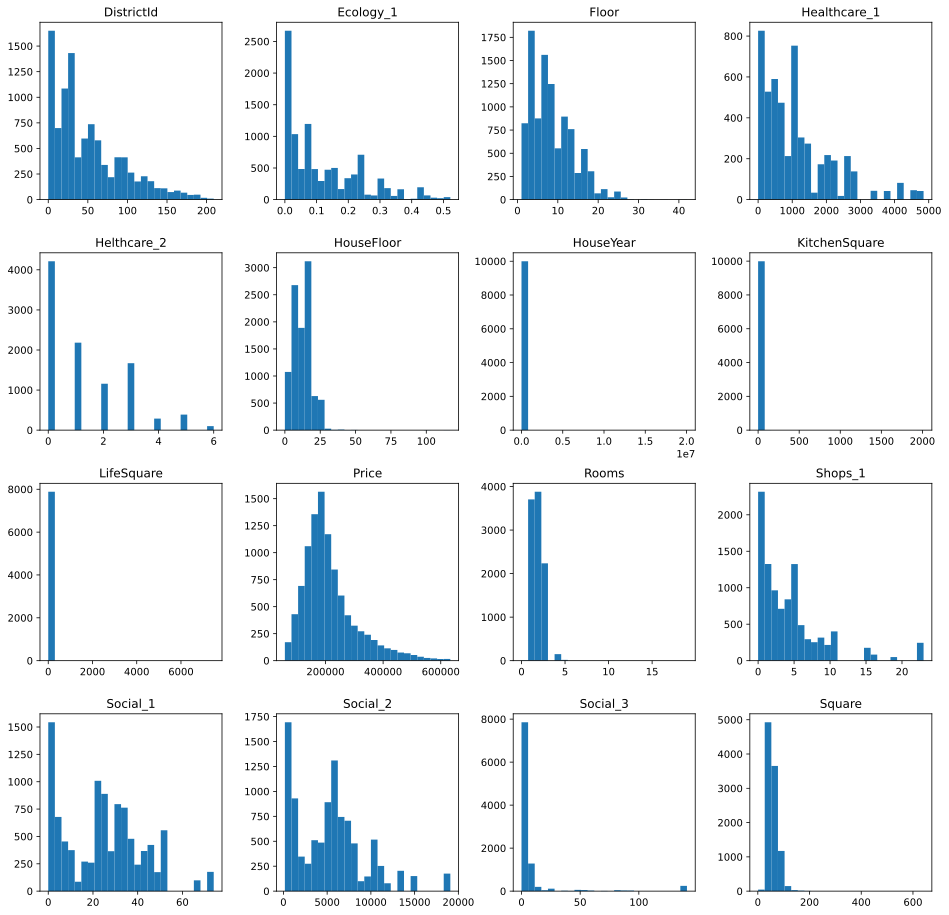

In [3515]:
df_num_features.hist(figsize=(16,16), bins=25, grid=False);

In [3516]:
DF_train = df1[df1["Price"].notnull()]
DF_test = df1[df1["Price"].isnull()]
DF_train.drop(['Id','DistrictId'], axis='columns', inplace=True)

In [3517]:
DF_test.drop(['Id','DistrictId', 'Price'], axis='columns', inplace=True)
DF_test

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
10000,2.0,49.882643,33.432782,6.0,6.0,14.0,1972,0.310199,1,1,11,2748,1,0,0,1
10001,2.0,69.263183,42.943174,7.0,1.0,6.0,1977,0.075779,1,1,6,1437,3,0,2,1
10002,1.0,40.407306,15.948246,12.0,2.0,5.0,1909,0.000000,1,1,30,7538,87,5,5,1
10003,2.0,73.046609,51.940842,9.0,22.0,22.0,2007,0.101872,1,1,23,4583,3,3,3,1
10004,1.0,47.527111,43.387569,5.0,17.0,17.0,2017,0.072158,1,1,2,629,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,3.0,67.133911,50.809797,6.0,5.0,9.0,1973,0.000170,1,1,36,5992,0,1,1,1
14996,1.0,40.198472,21.807061,10.0,12.0,17.0,2017,0.007122,1,1,1,264,0,0,1,1
14997,3.0,77.842178,48.282625,9.0,22.0,23.0,1989,0.090799,1,1,74,19083,2,5,15,1
14998,2.0,81.305222,50.409238,8.0,2.0,4.0,1977,0.072158,1,1,2,629,1,0,0,0


In [3518]:
features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1','Social_3','Social_2',
        'Helthcare_2', 'Shops_1', 'Shops_2']

target = 'Price'

In [3519]:
X = pd.DataFrame(DF_train, columns=features)
y = pd.DataFrame(DF_train, columns=[target])

In [3520]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [3521]:
scaler = StandardScaler()

In [3522]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=features)
DF_test_scaled = pd.DataFrame(scaler.transform(DF_test), columns=features)

## Лучшие  соотношение Train/Valid  показала  модель GradientBoostingRegressor

In [3523]:
gbmodel = GradientBoostingRegressor(n_estimators=102, max_depth=3, random_state=42)

In [3524]:
gbmodel.fit(X_train_scaled, y_train)

GradientBoostingRegressor(n_estimators=102, random_state=42)

In [3525]:
y_train_pred = gbmodel.predict(X_train_scaled) 

y_test_pred = gbmodel.predict(X_valid_scaled)

r2_train = r2_score(y_train, y_train_pred)

mae_train = mae(y_train, y_train_pred)

print(f'r2_train = {r2_train}, mae_train: {mae_train}')

r2_test = r2_score(y_valid, y_test_pred)

mae_test = mae(y_valid, y_test_pred)

print(f'r2_test = {r2_test}, mae_test: {mae_test}')

r2_train = 0.7656897781115344, mae_train: 29190.861711755235
r2_test = 0.7033428234163412, mae_test: 31220.243042204547


In [3526]:
price = model.predict(DF_test_scaled)
pd.DataFrame({ 'Id': df2['Id'], 'Price': price }).to_csv('IChurin_predictions.csv', index=False)

In [3527]:
df3= pd.read_csv('IChurin_predictions.csv')
df3

,Id,Price
0,725,170720.073416
1,15856,220837.149735
2,5480,206764.181754
3,15664,310521.958161
4,14275,139402.906921
...,...,...
4995,8180,262974.190262
4996,4695,121391.660751
4997,5783,341857.653225
4998,4780,315552.346594
